✅ Loaded 395 CSV files.
Total clauses: 150881
Label distribution:
 clause_type
time-of-essence                   630
time-of-the-essence               620
capitalized-terms                 590
definitions-and-interpretation    590
captions                          580
Name: count, dtype: int64
Number of classes: 395
Train samples: 120704 | Test samples: 30177

🔹 Training BiLSTM Baseline ...
Epoch 1/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2461 - loss: 4.4525
✅ Stopping early: validation accuracy reached 0.9920
425/425 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.2469 - loss: 4.4483 - val_accuracy: 0.9920 - val_loss: 0.2135
Restoring model weights from the end of the best epoch: 1.
944/944 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9917 - loss: 0.2141

🧪 BiLSTM Baseline Test Accuracy: 0.9915 | Test Loss: 0.2125
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

📊 BiLSTM Baseline Evaluation Report:
              precision    recall  f1-score   support

           0     0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9915, F1 (macro): 0.9852, ROC-AUC: 0.9999881180065631


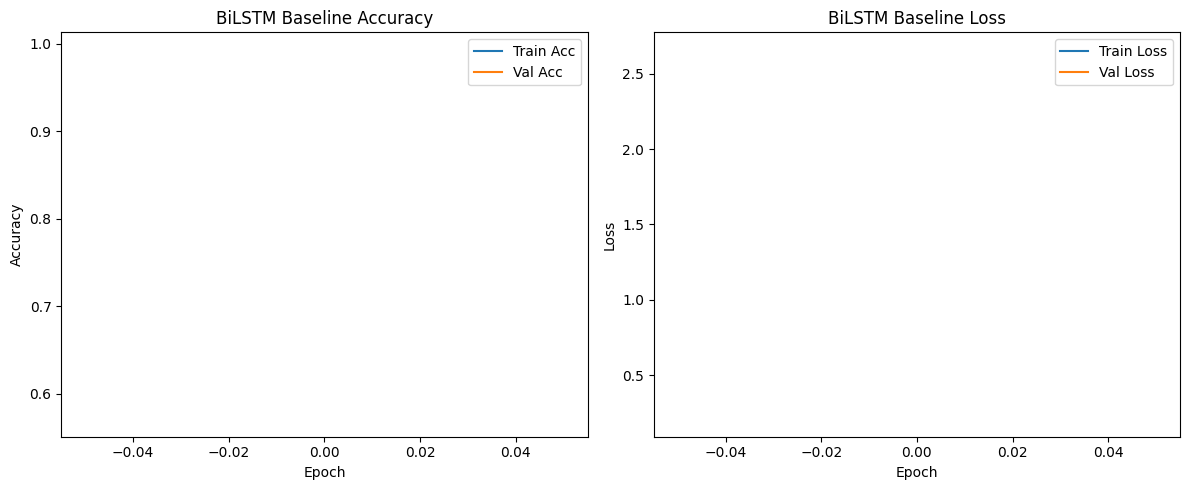


🔹 Training Attention Encoder ...
Epoch 1/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.3439 - loss: 3.7040 - val_accuracy: 0.7341 - val_loss: 0.8748
Epoch 2/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7499 - loss: 0.8438 - val_accuracy: 0.7920 - val_loss: 0.6603
Epoch 3/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8274 - loss: 0.5514 - val_accuracy: 0.8085 - val_loss: 0.6173
Epoch 4/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8739 - loss: 0.3935 - val_accuracy: 0.8202 - val_loss: 0.6050
Epoch 5/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9061 - loss: 0.2852 - val_accuracy: 0.8066 - val_loss: 0.6847
Epoch 6/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9225 - loss: 0.2372 - val_accuracy: 0.8155 - val_loss: 0.6599
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8174 - loss: 0.6026

🧪 Attention Encoder Test Accurac

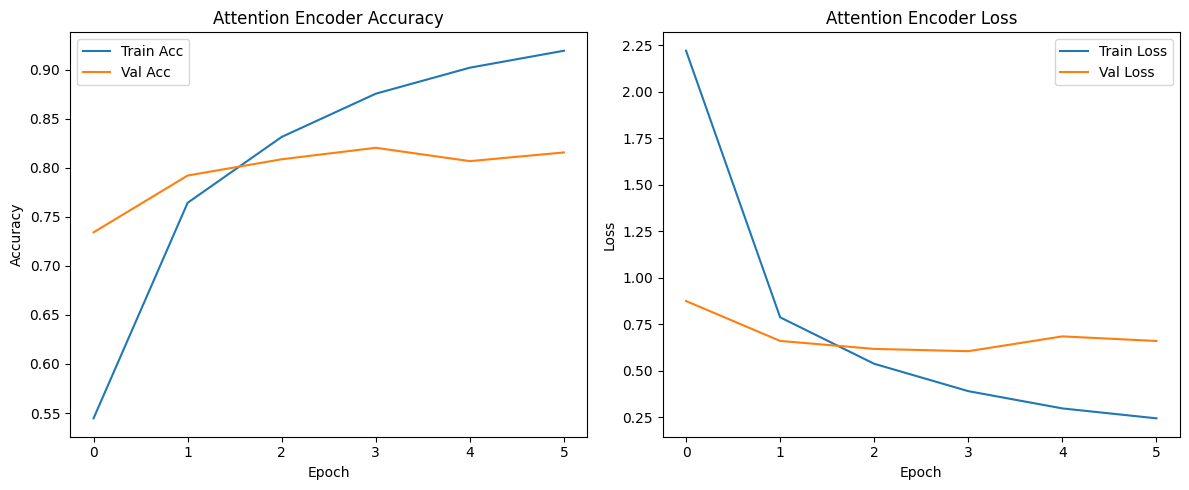


=== 🏁 Comparative Performance ===
               Model  Val_Accuracy  Test_Accuracy  Test_Loss        F1  \
0    BiLSTM Baseline      0.991964        0.99155   0.212533  0.985243   
1  Attention Encoder      0.820230        0.81973   0.595136  0.813067   

    ROC-AUC  
0  0.999988  
1  0.998511  

Results saved as 'baseline_results.csv'


In [ ]:

import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    Attention, GlobalAveragePooling1D, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, log_loss

# === STEP 1: Extract and Read All CSVs ===
zip_path = "/content/archive.zip"
extract_dir = "/content/data"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

csv_names_data = {}
for root, _, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".csv"):
            path = os.path.join(root, file)
            try:
                df = pd.read_csv(path)
                csv_names_data[file.replace(".csv", "")] = df
            except Exception as e:
                print(f"Skipping {file} → {e}")

print(f"✅ Loaded {len(csv_names_data)} CSV files.")

# === STEP 2: Combine and Clean Data ===
combined_df = pd.concat(csv_names_data.values(), ignore_index=True)
combined_df = combined_df.dropna(subset=['clause_text', 'clause_type']).reset_index(drop=True)

print("Total clauses:", len(combined_df))
print("Label distribution:\n", combined_df['clause_type'].value_counts().head())

# === STEP 3: Encode Labels ===
label_encoder = LabelEncoder()
combined_df['label_id'] = label_encoder.fit_transform(combined_df['clause_type'])
num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)

# === STEP 4: Text Preprocessing ===
texts = combined_df['clause_text'].astype(str).tolist()
labels = combined_df['label_id'].values

tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = 150
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

vocab_size = len(tokenizer.word_index) + 1
print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

# === STEP 5: Define Models ===
def build_bilstm(vocab_size, max_len, num_classes):
    inputs = Input(shape=(max_len,))
    x = Embedding(vocab_size, 128)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs, name="BiLSTM_Model")

def build_attention_encoder(vocab_size, max_len, num_classes):
    inputs = Input(shape=(max_len,))
    x = Embedding(vocab_size, 128)(inputs)
    query = Dense(128)(x)
    key = Dense(128)(x)
    value = Dense(128)(x)
    attn_output = Attention()([query, key, value])
    x = LayerNormalization()(x + attn_output)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs, name="Attention_Model")

# === STEP 6: Callbacks ===
class StopAt95Acc(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") and logs["val_accuracy"] >= 0.95:
            print(f"\n✅ Stopping early: validation accuracy reached {logs['val_accuracy']:.4f}")
            self.model.stop_training = True

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# === STEP 7: Training + Evaluation Function ===
def compile_train_evaluate(model, name):
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    print(f"\n🔹 Training {name} ...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=256,
        verbose=1,
        callbacks=[early_stop, StopAt95Acc()]
    )

    # --- Test Evaluation ---
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print(f"\n🧪 {name} Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

    # --- Predictions ---
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)

    print(f"\n📊 {name} Evaluation Report:")
    print(classification_report(y_test, y_pred, digits=4))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    try:
        auc = roc_auc_score(pd.get_dummies(y_test), preds, multi_class='ovr')
    except:
        auc = None
    print(f"Accuracy: {acc:.4f}, F1 (macro): {f1:.4f}, ROC-AUC: {auc}")

    # --- Training/Validation Curves ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "Model": name,
        "Val_Accuracy": max(history.history['val_accuracy']),
        "Test_Accuracy": test_acc,
        "Test_Loss": test_loss,
        "F1": f1,
        "ROC-AUC": auc
    }

# === STEP 8: Train Both Models ===
bilstm_model = build_bilstm(vocab_size, max_len, num_classes)
attn_model = build_attention_encoder(vocab_size, max_len, num_classes)

results = []
results.append(compile_train_evaluate(bilstm_model, "BiLSTM Baseline"))
results.append(compile_train_evaluate(attn_model, "Attention Encoder"))

# === STEP 9: Compare Results ===
results_df = pd.DataFrame(results)
print("\n=== 🏁 Comparative Performance ===")
print(results_df)
results_df.to_csv("baseline_results.csv", index=False)
print("\nResults saved as 'baseline_results.csv'")


Epoch 1/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.1675 - loss: 4.8960 - val_accuracy: 0.7822 - val_loss: 1.4013
Epoch 2/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.7940 - loss: 1.2820 - val_accuracy: 0.8251 - val_loss: 0.9839
Epoch 3/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8335 - loss: 0.9116 - val_accuracy: 0.8335 - val_loss: 0.8727
Epoch 4/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.8515 - loss: 0.7469 - val_accuracy: 0.8453 - val_loss: 0.7483
Epoch 5/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8678 - loss: 0.6151 - val_accuracy: 0.8552 - val_loss: 0.6829
Epoch 6/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.8811 - loss: 0.5248 - val_accuracy: 0.8612 - val_loss: 0.6475
Epoch 7/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8963 - loss: 0.4457 - val_accuracy: 0.8661 - val_loss: 0.6095
Epoch 8/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.9073 - loss: 0.3781 - 

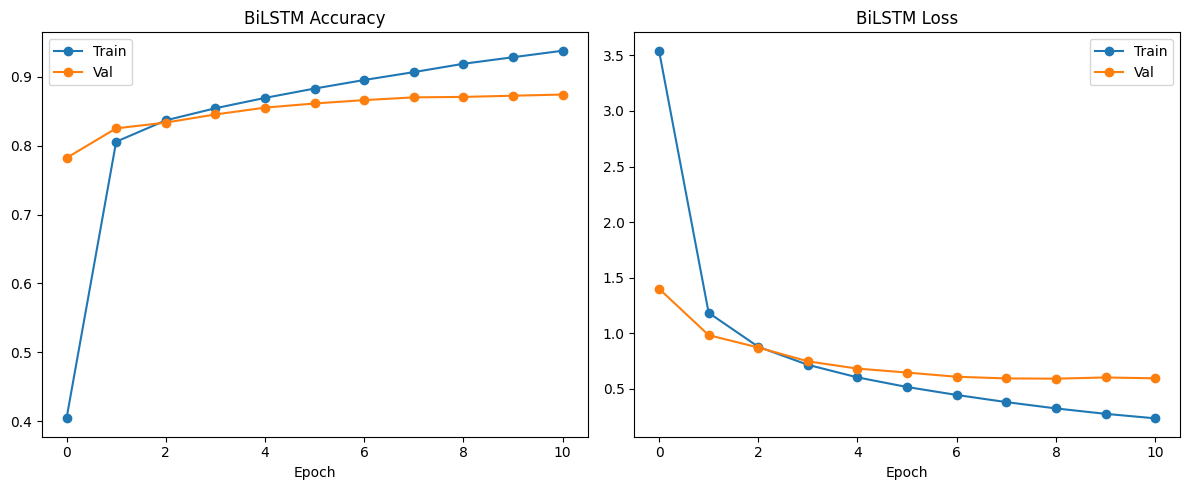

In [ ]:
import os, zipfile, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

# === Load and combine CSVs ===
zip_path = "/content/archive.zip"
extract_dir = "/content/data"
with zipfile.ZipFile(zip_path,"r") as z: z.extractall(extract_dir)
frames=[]
for root,_,files in os.walk(extract_dir):
  for f in files:
    if f.endswith(".csv"):
      try: frames.append(pd.read_csv(os.path.join(root,f)))
      except: pass
df=pd.concat(frames,ignore_index=True).dropna(subset=['clause_text','clause_type'])

# === Encode text & labels ===
lbl=LabelEncoder(); df['y']=lbl.fit_transform(df['clause_type'])
tok=Tokenizer(num_words=30000,oov_token="<OOV>")
tok.fit_on_texts(df['clause_text'])
X=pad_sequences(tok.texts_to_sequences(df['clause_text']),maxlen=150,padding='post')
y=df['y'].values
Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
V=len(tok.word_index)+1; C=len(lbl.classes_)

# === Callbacks ===
class Stop95(tf.keras.callbacks.Callback):
  def on_epoch_end(self, e, logs=None):
    if logs.get("val_accuracy",0)>=0.95:
      print(f"\n Reached 95% val_acc ({logs['val_accuracy']:.3f}), stopping."); self.model.stop_training=True
stop95=Stop95(); early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)

# === Model ===
inp=Input((150,))
x=Embedding(V,128)(inp)
x=Bidirectional(LSTM(128,return_sequences=False))(x)
x=Dropout(0.4)(x)
out=Dense(C,activation="softmax")(x)
model=tf.keras.Model(inp,out)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# === Train ===
hist=model.fit(Xtr,ytr,validation_split=0.1,epochs=20,batch_size=256,callbacks=[stop95,early],verbose=1)

# === Test ===
tl,ta=model.evaluate(Xte,yte,verbose=1)
print(f"\n BiLSTM Test Accuracy={ta:.4f} | Loss={tl:.4f}")

# === Report ===
preds=model.predict(Xte); yp=np.argmax(preds,1)
print(classification_report(yte,yp,digits=4))

# === Curves ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],'-o',label='Train')
plt.plot(hist.history['val_accuracy'],'-o',label='Val')
plt.title("BiLSTM Accuracy"); plt.xlabel("Epoch"); plt.legend()
plt.subplot(1,2,2)
plt.plot(hist.history['loss'],'-o',label='Train')
plt.plot(hist.history['val_loss'],'-o',label='Val')
plt.title("BiLSTM Loss"); plt.xlabel("Epoch"); plt.legend()
plt.tight_layout(); plt.show()


Epoch 1/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.3154 - loss: 3.8827 - val_accuracy: 0.6801 - val_loss: 1.2054
Epoch 2/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7081 - loss: 1.0951 - val_accuracy: 0.7347 - val_loss: 0.9460
Epoch 3/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7924 - loss: 0.7200 - val_accuracy: 0.7356 - val_loss: 0.9553
Epoch 4/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8477 - loss: 0.5087 - val_accuracy: 0.7511 - val_loss: 0.9500
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7394 - loss: 0.9427

🧪 Attention Encoder Test Accuracy=0.7433 | Loss=0.9321
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.7812    0.7143    0.7463        70
           1     0.8028    0.8143    0.8085        70
           2     0.8551    0.8429    0.8489        70
           3     0.5686    0.4677    0.5133        62
           4     0.5375    0.7963    0.6418        54
           5     0.9474    0.9730    0.9600        74
           6     0.6786    0.7125    0.6951        80
           7     0.8778    0.8404    0.8587        94
           8     0.8571    0.8333    0.8451        72
           9     0.9327    0.9700    0.9510       100
          10     0.6610    0.3900    0.4906       100
          11     0.6875    0.4583    0.5500        96
          12     0.8438    0.7297    0.7826        74
          13     0.4719    0.5250    0.4970        80
          14     0.6600    0.4342    0.5238        76
          15     0.8384    0.9022    0.8691        92
          16     0.5556    0.6061    0.5797        66
          17     0.8636    

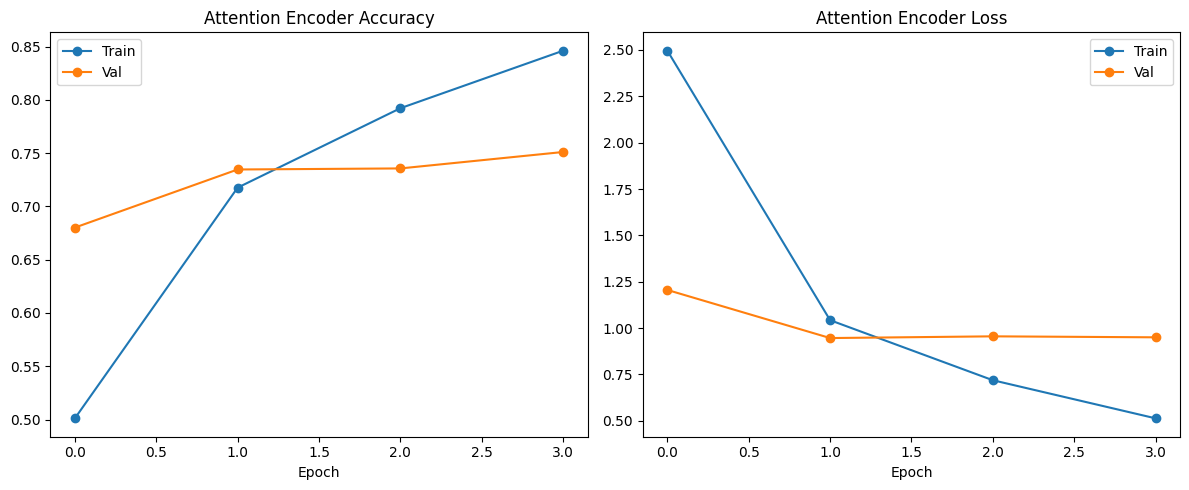

In [ ]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Attention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report



class Stop95(tf.keras.callbacks.Callback):
  def on_epoch_end(self,e,logs=None):
    if logs.get("val_accuracy",0)>=0.95:
      print(f"\n✅ Reached 95% val_acc ({logs['val_accuracy']:.3f}), stopping."); self.model.stop_training=True
stop95=Stop95(); early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)


inp=Input((150,))
x=Embedding(V,128)(inp)
q=Dense(128)(x); k=Dense(128)(x); v=Dense(128)(x)
att=Attention()([q,k,v])
x=LayerNormalization()(x+att)
x=GlobalAveragePooling1D()(x)
x=Dropout(0.4)(x)
out=Dense(C,activation='softmax')(x)
att_model=Model(inp,out)
att_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

hist=att_model.fit(Xtr,ytr,validation_split=0.1,epochs=20,batch_size=256,callbacks=[stop95,early],verbose=1)


tl,ta=att_model.evaluate(Xte,yte,verbose=1)
print(f"\n🧪 Attention Encoder Test Accuracy={ta:.4f} | Loss={tl:.4f}")


preds=att_model.predict(Xte); yp=np.argmax(preds,1)
print(classification_report(yte,yp,digits=4))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],'-o',label='Train')
plt.plot(hist.history['val_accuracy'],'-o',label='Val')
plt.title("Attention Encoder Accuracy"); plt.xlabel("Epoch"); plt.legend()
plt.subplot(1,2,2)
plt.plot(hist.history['loss'],'-o',label='Train')
plt.plot(hist.history['val_loss'],'-o',label='Val')
plt.title("Attention Encoder Loss"); plt.xlabel("Epoch"); plt.legend()
plt.tight_layout(); plt.show()
